<a href="https://colab.research.google.com/github/rafalsza/moje/blob/master/prophet_prediction_vbt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_ta
!pip install vectorbt
!pip install python-binance
!pip install ccxt
!pip install prophet

In [ ]:
import matplotlib.pyplot as plt
from fbprophet import Prophet
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt
import binance
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

0it [00:00, ?it/s]

             ds         y
0    2017-08-17   4285.08
1    2017-08-18   4108.37
2    2017-08-19   4139.98
3    2017-08-20   4086.29
4    2017-08-21   4016.00
...         ...       ...
1668 2022-03-12  38807.36
1669 2022-03-13  37777.34
1670 2022-03-14  39671.37
1671 2022-03-15  39280.33
1672 2022-03-16  39648.30

[1673 rows x 2 columns]


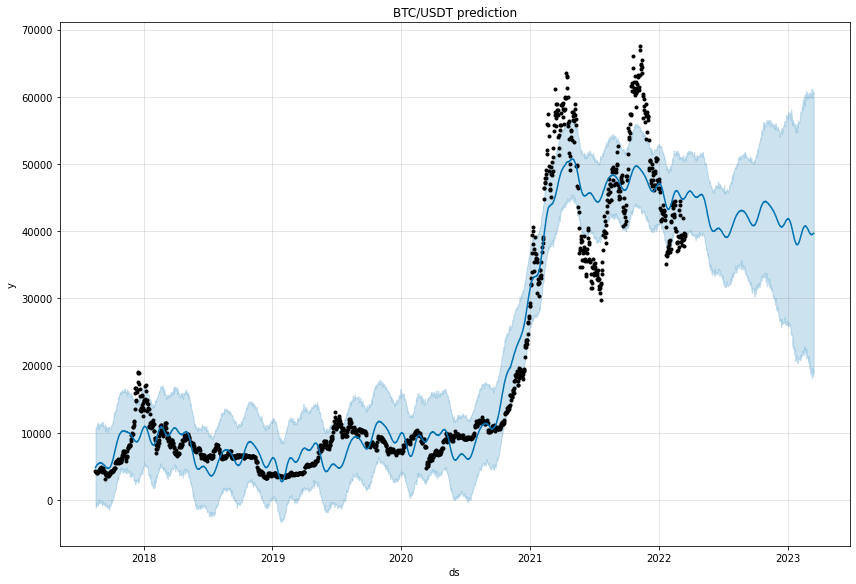

In [ ]:
cols = ['Close']
coin = 'BTC'+'/'
symbol = coin + 'USDT'
df = vbt.CCXTData.download(symbol, start='7 years ago UTC', timeframe='1d').get(cols)
df.reset_index(inplace=True)
df.columns = ["ds", "y"]
df['ds'] = df['ds'].dt.tz_localize(None)
df.ds = pd.to_datetime(df.ds,unit='ms')
print(df)
model = Prophet(daily_seasonality=True)
model.fit(df)
future = model.make_future_dataframe(365,freq='D')
forecast = model.predict(future)
model.plot(forecast, figsize=(12,8))
plt.title(f'{symbol.upper()} prediction')
plt.show()

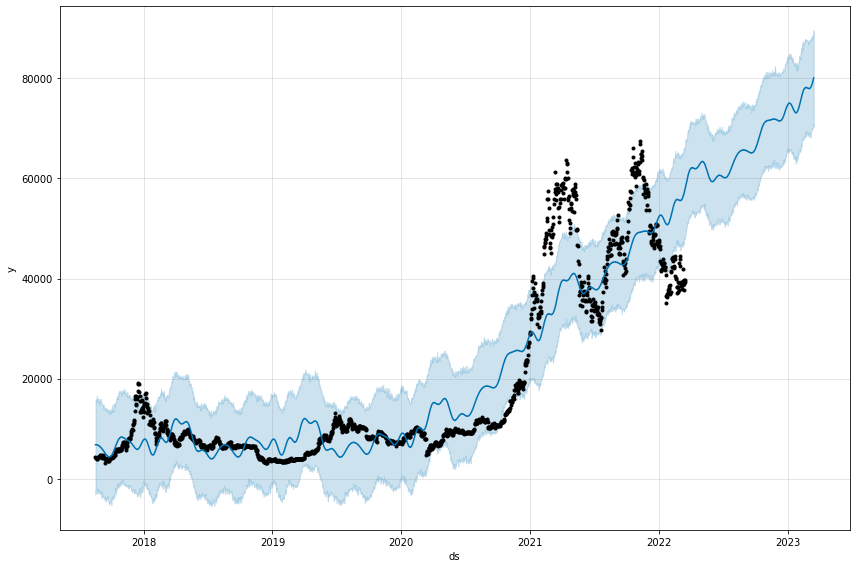

In [ ]:

m = Prophet(daily_seasonality=True,changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=365, freq='D')
fcst = m.predict(future)
fig = m.plot(fcst,figsize=(12,8))

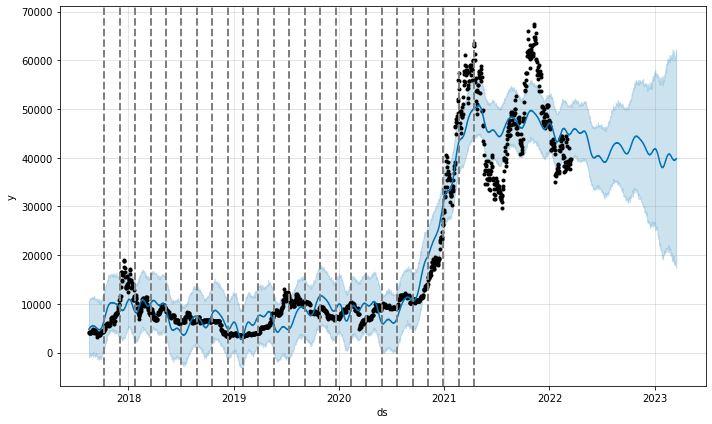

In [ ]:
m = Prophet(daily_seasonality=True)
m.fit(df)
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)
fig = m.plot(forecast)
for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)

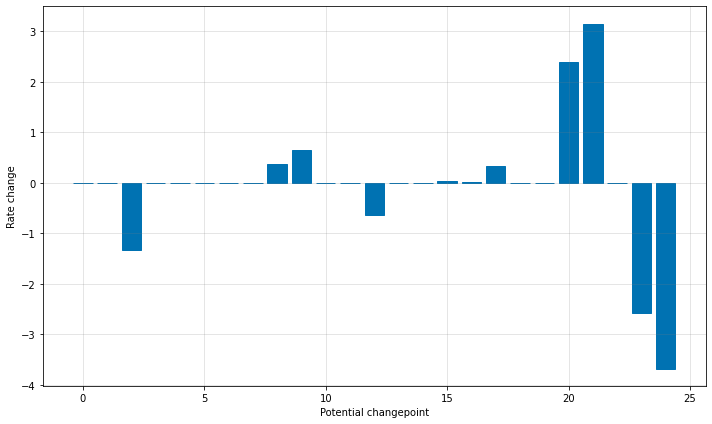

In [ ]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

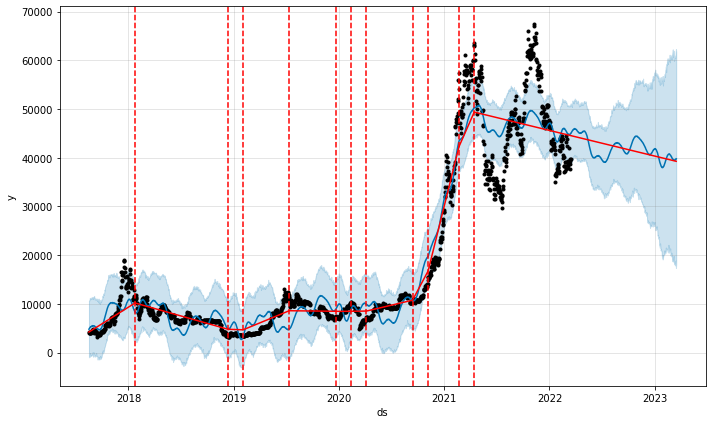

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


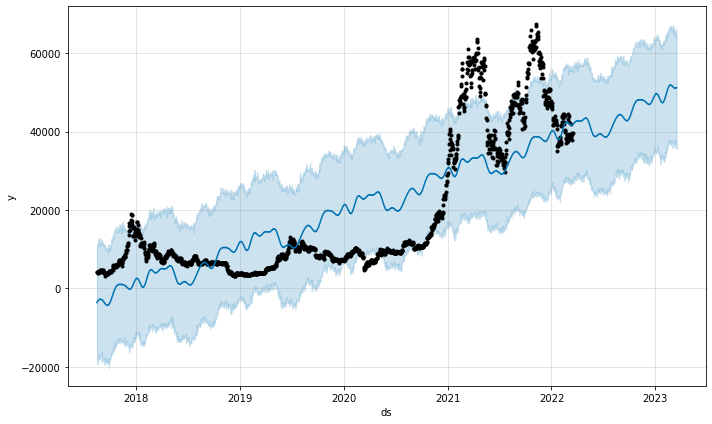

In [ ]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2033,2023-03-12,51039.053745,36425.102868,65719.012277
2034,2023-03-13,51094.121331,36490.047157,65594.062706
2035,2023-03-14,51079.014522,36055.594847,66450.904104
2036,2023-03-15,51166.416226,35980.272840,66496.615787
2037,2023-03-16,51130.297549,35877.585891,65015.042801


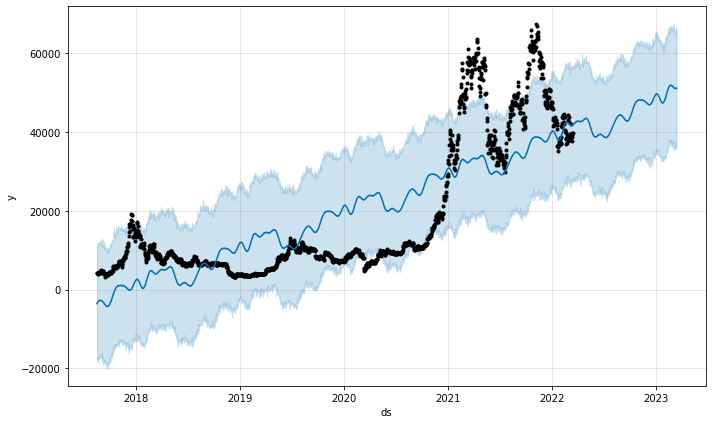

In [ ]:
fig1 = m.plot(forecast)

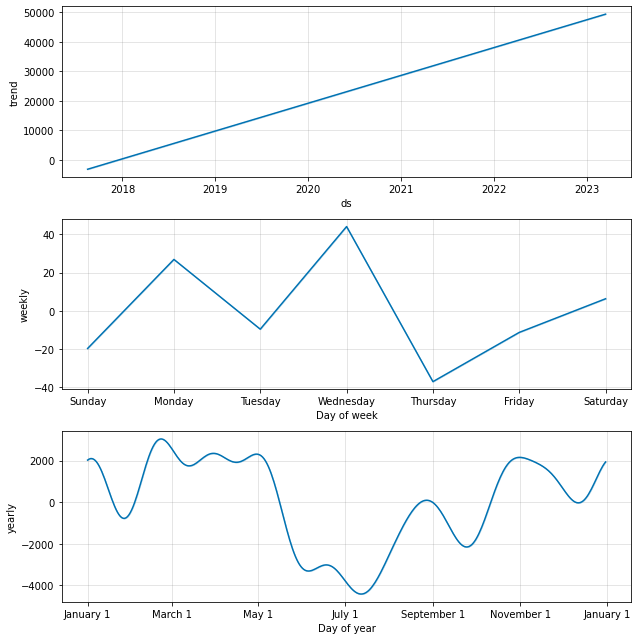

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

**What Happens if you Day Trade Crypto with Facebook Prophet?**

https://medium.com/geekculture/what-happens-if-you-day-trade-crypto-with-facebook-prophet-84df66c31657

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import calendar
from tqdm import tqdm
import numpy as np
import random
import plotly.express as px
from prophet import Prophet

In [ ]:
def getIntradayPrices(crypto, n_hours, training_hours, mov_avg):
    """
    Gets crypto prices from now to N days ago and training amount will be in addition 
    to the number of days to train. (According to the EOD documentation: The maximum 
    periods between ‘from’ and ‘to’ are 120 days for 1-minute interval, 600 days 
    for 5-minute interval and 7200 days for 1 hour interval.)
    
    There also appears to be a time delay on the data of about 15-20 hours, which 
    is added to the from(ago) variable.
    """
    
    # Getting the time from N hours ago
    ago = datetime.utcnow() - timedelta(hours=n_hours+training_hours+15)
    
    # Getting the unix timestamp format for the intraday data from the API
    timestamp_unix = str(calendar.timegm(ago.utctimetuple()))

    cols = ['Open','Close']
    
    # Retrieving price data
    resp = vbt.CCXTData.download(crypto, start=timestamp_unix, timeframe='1h').get(cols)
    
    # Price formatting for the dataframe
    prices = pd.DataFrame(resp)
        
    # Filling NaNs with the most recent values for any missing data
    prices = prices.fillna(method='ffill')
    
    # Getting the N Day Moving Average and rounding the values for some light data preprocessing
    prices['MA'] = prices[['Open']].rolling(
        window=mov_avg
    ).mean().apply(lambda x: round(x, 6))

    # Resetting format for FBP
    prices.reset_index(inplace=True)
    
    prices['ds'] = prices['Open time'].dt.tz_localize(None)
    
    prices = prices.rename(
        columns={"MA": "y"}
    )
    
    return prices

In [ ]:
def fbpTrainPredict(df, forecast_hours):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(
        periods=forecast_hours,
        freq="H",
        include_history=False
    )
        
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
def runningFBP(prices, forecast_hours, training_hours):
    """
    Runs Facebook Prophet to get predictions over a set period 
    of time. Uses FBP to train and predict every hour and gets the 
    price forecasts in the next N hours.
    """
    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model each day
    for i in tqdm(range(training_hours, len(prices))):

        # Training and Predicting the last hour on the forecast
        forecast = fbpTrainPredict(
            prices[i-training_hours:i], 
            forecast_hours
        ).tail(1)[[
            'ds',
            'yhat',
            'yhat_lower',
            'yhat_upper'
        ]]
        
        # Adding the forecast predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
                
    # Prepping for merge by converting date values to be the same type
    pred_df['ds'] = pred_df['ds'].apply(str)

    prices['ds'] = prices['ds'].apply(str)
    
    # Shifting the forecasts back in order to compare it to the 'current' open values
    pred_df[['yhat', 'yhat_lower', 'yhat_upper']] = pred_df[['yhat', 'yhat_lower', 'yhat_upper']].shift(-forecast_hours)
    
    # Merging with the prices DF in order to compare values for positions later
    merge_df = prices[['ds', 'Open']].merge(
        pred_df,
        on='ds',
        how='outer'
    ).dropna().set_index('ds')

    return merge_df

In [ ]:
def fbpPositions(pred_df, short=True):
    """
    Gets positions based on the predictions and the actual values. This
    is the logic of the trading strategy.
    """
    if pred_df['Open'] < pred_df['yhat_lower']:
        return 1
    elif pred_df['Open'] > pred_df['yhat_upper'] and short:
        return -1
    else:
        return 0

In [ ]:
def backtestPerformanceVis(ticker, n_hours, training_hours, mov_avg, forecast_hours):
    """
    Consolidates the previous functions that support the backtesting process.
    """
    # Getting Price data
    print("Getting price data...")
    prices = getIntradayPrices(
        crypto=ticker, 
        n_hours=n_hours, 
        training_hours=training_hours, 
        mov_avg=mov_avg
    )

    # Predicting over time
    print("Running predictions...")
    pred_df = runningFBP(
        prices, 
        forecast_hours=forecast_hours, 
        training_hours=training_hours
    )
    
    # Adding sentiment positions to the prediction DF
    print("Getting positions...")
    positions = pred_df

    # Getting forecast prophet positions
    positions['fbp_positions'] = positions.apply(
        lambda x: fbpPositions(x, short=True), 
        axis=1
    )

    # Buy and hold position
    positions['buy_hold'] = 1

    # Random positions
    positions['random_positions'] = random.choices(
        [1,0,-1], k=len(positions)
    )
    
    # Getting returns each hour
    print("Performing the backtest...")
    log_returns = prices[['ds', 'Open']].set_index(
        'ds'
    ).loc[positions.index].apply(np.log).diff()
    
    # The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
    bt_positions = positions[[
        'buy_hold', 
        'random_positions',
        'fbp_positions'
    ]].shift(1)

    # The returns during the backtest
    returns = bt_positions.multiply(
        log_returns['Open'], 
        axis=0
    )

    # Inversing the log returns to get daily portfolio balance
    performance = returns.cumsum().apply(
        np.exp
    ).dropna().fillna(
        method='ffill'
    )
    
    # Displaying the final balance of the portfolio
    print("Final Performance:")
    display(performance.tail(1))
    
    # Visualizing results
    fig = px.line(
        performance,
        x=performance.index,
        y=performance.columns,
        title='FBProphet, Buy&Hold, Random Positions',
        labels={"value": "Portfolio Balance",
                "index": "Date"}
    )

    return fig.show()

In [ ]:
backtestPerformanceVis(
    ticker="BTC/USDT", 
    n_hours=300, 
    training_hours=200, 
    mov_avg=5, 
    forecast_hours=5
)

Getting price data...


0it [00:00, ?it/s]

Running predictions...


100%|██████████| 315/315 [09:23<00:00,  1.79s/it]

Getting positions...
Performing the backtest...
Final Performance:


,buy_hold,random_positions,fbp_positions
ds,,,
2022-03-16 17:00:00,0.954395,0.950263,0.965122
